In [14]:
from keras.models import load_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import cv2


from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
from IPython.display import Image, display

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import AveragePooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.optimizers import Adam

In [15]:
# this "normalize" function takes an image as input and transforms its pixel values to be within the range of [-1, 1], which is a common range for neural network input data.
def normalize(image):
  return(image/255 -0.5)*2

#his function is essentially the reverse of the previous normalize function you shared. It takes a normalized image (which typically has pixel values in the range [-1, 1]) and converts it back to a standard image format with pixel values in the range [0, 255].
def to_image(normalized_image):
  return((normalized_image/2 +0.5)*255).astype(np.uint8)

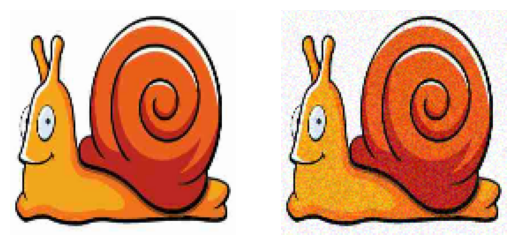

In [16]:
im= cv2.imread("snail.jpg")[:,:,::-1] #BGR TO RGB
im= cv2.resize(im,(128,128))
noise_intensity= 25
noise= np.random.randint(-noise_intensity,noise_intensity,size=im.shape)
im_noise= (im+noise).clip(0,255).astype(np.uint8)

#to ensure that the image is in 8 bit format suitable for imshow function
plt.subplot(121); plt.axis('off'); plt.imshow(to_image(normalize(im))) # line sets up the first subplot with a grid of 1 row and 2 columns and selects the first subplot (i.e., the left subplot).
plt.subplot(122); plt.axis('off'); plt.imshow(im_noise)
plt.show()

In [17]:
def Unet(pretrained_weights= None, input_size= (128,128,3)):

  input_img= Input(input_size)

  # ENCODER


  conv1= Conv2D (32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_img)
  conv1= BatchNormalization()(conv1)
  conv1=  Conv2D (32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
  conv1= BatchNormalization(name= 'conv_ct_32')(conv1)
  pool1= MaxPool2D(pool_size=(2,2))(conv1)  #192*192

  conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
  conv2 = BatchNormalization(name='conv_ct_64')(conv2)
  pool2 = MaxPool2D(pool_size=(2, 2))(conv2) #96x96

  conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
  conv3 = BatchNormalization()(conv3)
  conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
  conv3 = BatchNormalization(name='conv_ct_128')(conv3)
  pool3 = MaxPool2D(pool_size=(2, 2))(conv3) #48x48

  conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
  conv4 = BatchNormalization()(conv4)
  conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
  conv4 = BatchNormalization(name='conv_ct_256')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPool2D(pool_size=(2, 2))(drop4) #24x24


  conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
  conv5 = BatchNormalization()(conv5)
  conv5 = Conv2D(512, 3, activation='tanh', padding='same', kernel_initializer='he_normal')(conv5)
  conv5 = BatchNormalization(name='conv_ct_512')(conv5)
  conv5 = Dropout(0.5)(conv5)
  #pool5_ct = MaxPool2D(pool_size=(2, 2))(conv5) #12x12

  #DECODER


  up6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5)) #24x24
  up6 = BatchNormalization()(up6)
  merge6 = concatenate([drop4, up6], axis=3)  # cm: cross modality
  conv6 = Conv2D(128, 3, activation='tanh', padding='same', kernel_initializer='he_normal')(merge6)
  conv6 = BatchNormalization()(conv6)
  conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
  conv6 = BatchNormalization(name='decoder_conv_256')(conv6)



  up7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
  up7 = BatchNormalization()(up7)
  merge7 = concatenate([conv3, up7], axis=3)  # cm: cross modality
  conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
  conv7 = BatchNormalization()(conv7)
  conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
  conv7 = BatchNormalization(name='decoder_conv_128')(conv7)



  up8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
  up8 = BatchNormalization()(up8)
  merge8 = concatenate([conv2, up8], axis=3)  # cm: cross modality
  conv8 = Conv2D(64, 3, activation='tanh', padding='same', kernel_initializer='he_normal')(merge8)
  conv8 = BatchNormalization()(conv8)
  conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
  conv8 = BatchNormalization(name='decoder_conv_64')(conv8)

  up9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
  up9 = BatchNormalization()(up9)
  merge9 = concatenate([conv1, up9], axis=3)  # cm: cross modality
  conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
  conv9 = BatchNormalization()(conv9)
  conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
  conv9 = BatchNormalization(name='decoder_conv_32')(conv9)

  conv10 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(conv9)
  conv10 = BatchNormalization()(conv10)
  conv11 = Conv2D(filters=3, kernel_size=3,  activation='tanh', padding='same', name='conv12')(conv10)


  model = Model(inputs=input_img, outputs=conv11)

  return model

In [18]:
model= Unet()
model.compile(optimizer=Adam(lr=0.0001), loss='mean_absolute_error')

In [19]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# display(Image(filename='model_plot.png'))

In [20]:
#This line generates a random NumPy array x with the same shape as im but with an additional dimension of size 1 added at the beginning. The additional dimension is created by (1,). The values in x are drawn from a uniform distribution between -1 and 1 using the expression * 2 - 1. So, x contains random values in the range [-1, 1].
x = np.random.random(size=((1,) + im.shape)) * 2 - 1
#None is used to add an additional dimension to the im_noise array.
y = normalize(im_noise[None, :])
[x.shape, y.shape]

[(1, 128, 128, 3), (1, 128, 128, 3)]

In [21]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [22]:
def calculate_ssim(image1, image2):
    # Convert the images to grayscale, as SSIM is usually calculated on grayscale images
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM value
    ssim_value, _ = ssim(gray_image1, gray_image2, full=True)

    return ssim_value

In [ ]:
plt.axis('off')
plt.title('Iteration 0')
plt.imshow(to_image(x[0]))
plt.show()

iterations =20            # in hundreds
results = np.empty(x.shape)
epochs_l=[]
psnr_l= []

for i in range(iterations):
  model.fit(x,y, epochs=10, batch_size=1, verbose=0)
  output= model.predict(x)
  psnr= PSNR(im,to_image(output[0]))
  psnr_l.append(psnr)
  epochs_l.append(i*50)
  print(f"PSNR value is {psnr} dB")
  results = np.append(results, output, axis=0)
  plt.axis('off')
  plt.title('Iteration '+ str((i+1)*100))
  plt.imshow(to_image(output[0]))
  plt.show()

PSNR value is 29.58274614776937 dB
PSNR value is 29.592157126036813 dB


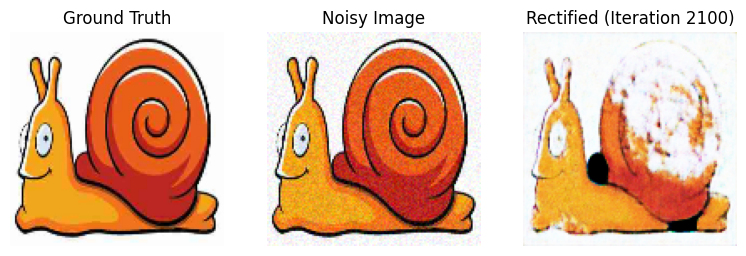

In [24]:
plt.figure(figsize=(16,6))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(im)
plt.subplot(152); plt.axis('off'); plt.title('Noisy Image'); plt.imshow(im_noise)
# i=10; plt.subplot(153); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
# i=16; plt.subplot(154); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
i=20; plt.subplot(153); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
psnr= PSNR(im,im_noise)
print(f"PSNR value is {psnr} dB")
psnr= PSNR(im,to_image(results[20]))
print(f"PSNR value is {psnr} dB")
plt.show()

In [25]:
image1 = im
image2 = to_image(results[20])

# Calculate SSIM value
ssim_value = calculate_ssim(image1, image2)
print(ssim_value)

0.47728968180106335


Text(0, 0.5, 'PSNR')

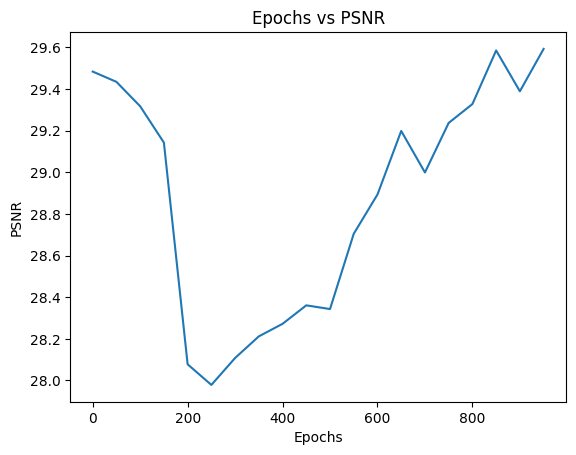

In [26]:
plt.plot(epochs_l, psnr_l)
plt.title('Epochs vs PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')